In [6]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
SAVEFIG = False

In [7]:
# Initializing matrix
num_nodes = 100
np.random.seed(2)

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

# define targets
time_points = np.arange(600)
targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5

In [8]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = 25
inh_weight_sum = 25
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [9]:
# define output params
gainout= 1.15
shiftout= -2.5
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

In [10]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5
        self.i = 0

    def f_tensor(self, x_tensor, u_tensor, r_tensor):
        # this_input_tensor = torch.matmul(tensor(self.input_weight_matrix), tensor([[self.inputs[self.i]]]))
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor + u_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor - self.shift_tensor))
        return y_tensor
     
    def f(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, u_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        dydx, dydu, dydr = jacobian(self.f_tensor,(x_tensor, u_tensor, r_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Ju_tensor = dydu.squeeze(dim=(1,3))
        Jr_tensor = dydr.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Ju = Ju_tensor.numpy()
        Jr = Jr_tensor.numpy()
        return Jx, Ju, Jr

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Verfify mysys is the same as RNN

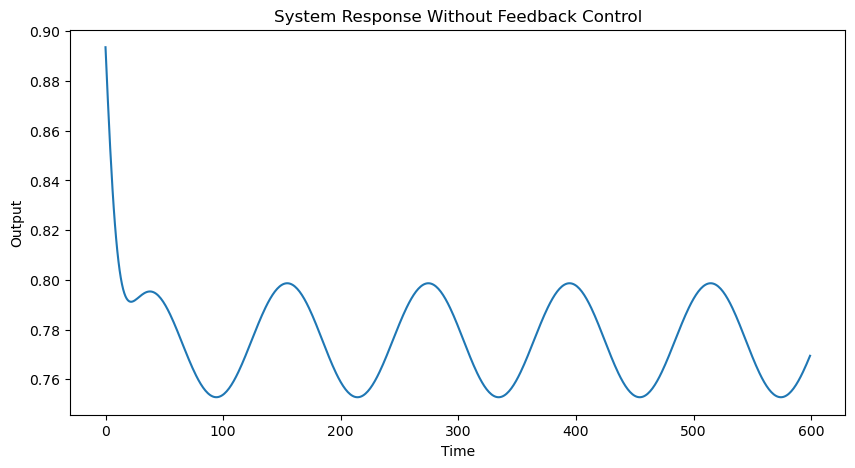

In [16]:
# Simulation Without Control
x = sigmoid_np(init_gain * init_state.copy() - init_shift)
u = init_state.copy() * 0
xs = []
outputs_ff = []

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # input
    this_input = targets[i+1]
    r = feedback_weight_matrix @ np.array([[this_input]])

    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()

    F, G, B = jnn.jacob(x, u, r)
    
    # save
    xs.append(x)
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

In [14]:
network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
        timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), shiftout=shiftout, gainout=gainout, target=targets)
states, activations, outputs = network.simulate(60)

Text(0.5, 0, 'Time point')

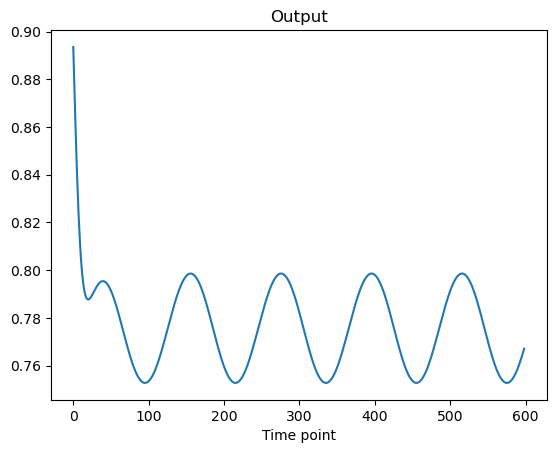

In [15]:
plt.plot(outputs)
plt.title("Output")
plt.xlabel("Time point")

### Discrete Tracking Control

In [18]:
# calculate the desired output before the output sigmoid
def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)
y_tildes = (inv_sigmoid_np(targets) + shiftout) / gainout

In [41]:
# Simulate with control
x = init_state.copy()
xs, us, outputs_fb_beforesig, outputs_fb = [], [], [], []

# constants
R = np.eye(num_nodes) * 0.001
Q1 = np.eye(num_nodes) * 0.001
Q2 = np.eye(1) * 10

for t in time_points[:-1]:

    jnn.i = t

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # input
    this_input = targets[i+1]
    r = feedback_weight_matrix @ np.array([[this_input]])
    
    # linear approxmation of nonlinear system
    # linear approximate F and G and B
    F, G, B = jnn.jacob(x, u, r)

    # get H
    H = output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]
    x_tilde = L @ np.array([[y_tilde]])

    # get the control input u
    # backward solve
    S_t2 = Q
    b_t2 = np.zeros(shape=(num_nodes, 1))
    S_t1 = F.T @ (S_t2 - S_t2 @ G @ np.linalg.inv(G.T @ S_t2 @ G + R) @ G.T @ S_t2) @ F + Q
    K_T_t1 = -np.linalg.inv(G.T @ S_t2 @ G + R) @ G.T @ S_t2 @ F
    b_t1 = (F.T + K_T_t1.T @ G.T) @ b_t2 - Q @ x_tilde
    # calculate u_t
    u_star = -np.linalg.inv(G.T @ S_t1 @ G + R) @ G.T @ (S_t1 @ F @ x + b_t1)
    u = np.linalg.pinv(G) @ (G @ u_star - B @ r)
    
    # update x
    x1 = jnn.f(x, u, r)
    x = x1.copy()
    
    # save
    xs.append(x)
    us.append(u)
    outputs_fb_beforesig.append(output_beforesig.item())
    outputs_fb.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_fb_beforesig.append(output_beforesig.item())
outputs.append(output.item())

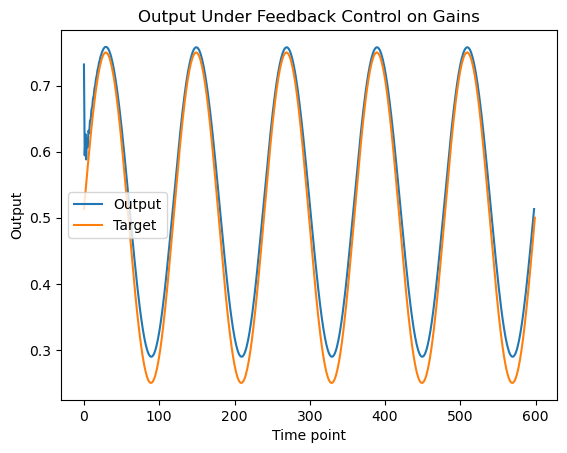

In [40]:
plt.plot(outputs_fb, label='Output')
plt.plot(targets, label='Target')
plt.title('Output Under Feedback Control on Gains')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_output.png")

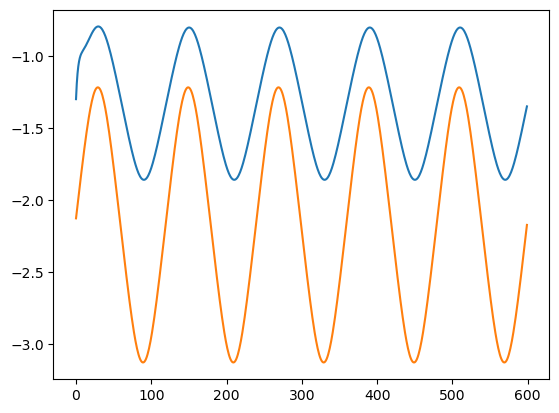

In [32]:
plt.plot(outputs_fb_beforesig)
plt.plot(y_tildes)